# A first glance at the dataset

### Background
I attended (and judged) the 2017 Rutgers ARESTY research symposium, and one of the posters showed some interesting results regarding disparaties in access to health; specifically, there was a correlation between waiting times in health care facilities and ethnicity. I decided to check out the data myself (which, if I recall correctly, are from the Medicare Current Beneficiary Survey from 2013), and see what other interesting tidbits were in there.

In [1]:
from IPython.display import display_pretty
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

In [2]:
mcbs_datafile = os.path.join(os.getcwd(), '..', 'data', 'ATCPUF13.csv')
df = pd.read_csv(mcbs_datafile)

In [3]:
df.head()

,PUF_ID,SVYYR,IV_AGE,IV_SEX,IV_RACE,D_RE_AGE,D_ARMED,D_INCOME,D_INC_IMP,D_EDU,...,CS1YR091,CS1YR092,CS1YR093,CS1YR094,CS1YR095,CS1YR096,CS1YR097,CS1YR098,CS1YR099,CS1YR100
0,21892,2013,1,1,1,1,2.0,1,1,2,...,226,288,295,283,222,265,261,286,230,273
1,13193,2013,2,1,1,2,1.0,1,1,1,...,4649,3913,5101,3893,4632,721,4595,3936,4163,3899
2,29011,2013,3,2,1,3,2.0,2,1,2,...,4725,4659,865,990,4765,4904,801,899,5231,4927
3,18152,2013,3,2,1,3,2.0,2,1,3,...,2411,10760,11040,1935,2278,10383,2096,11377,12775,1715
4,32650,2013,3,2,1,4,2.0,2,1,1,...,736,3771,4481,618,710,4039,791,3616,4166,720


Okay, 459 columns is a lot. Also, everything has been encoded so that's a bit of a pain in the butt to examine. However, we can look at the documentation in order to make sense of it. First, let's try to replicate the results that I had seen, which involved the two main variables *ethnicity* and *waiting time*. Table 1 of the user guide suggests that the race group will be preceded with `IV_`, and that waiting time will probably be preceded by `ACC_`. 

I'll later probably want to pull demographic information such as income, education, etc.

In [4]:
print([k.strip('IV_') for k in df.keys() if k.startswith(('IV_'))])
print([k.strip('ACC_') for k in df.keys() if k.startswith(('ACC_'))])

['AGE', 'SEX', 'RACE']
['OPDFLAG', 'OPDMCOND', 'OPDTESTS', 'OPDFOLUP', 'OPDCHKUP', 'OPDRFRL', 'OPDSURGY', 'OPDPSHOT', 'OPDTSHOT', 'OPDPMED', 'OPDOTHER', 'OPDAPPT', 'OPDDRTEL', 'D_OPAPPT', 'D_OPTIME', 'MDSPCLTY', 'MDFLAG', 'MDAPPT', 'MDDRTEL', 'D_MDAPPT', 'D_MDTIME', 'HCTROUBL', 'HCDELAY', 'MCQUALTY', 'MCAVAIL', 'MCEASE', 'MCCOSTS', 'MCINFO', 'MCFOLUP', 'MCCONCRN', 'MCSAMLO', 'MCSPECAR', 'MCTELANS', 'MCAMTPAY', 'MCDRGLST', 'MCFNDPCY', 'MCRECPLN', 'DHEVHEAR', 'DHPLAN', 'DHTHISYR', 'DHSTART', 'DHEND', 'DHWORRY', 'MCDISSFY', 'MCWORRY', 'MCAVOID', 'MCSICK', 'MCDRSOON', 'MCDRNSEE', 'MCDRATMP', 'SCRMAIN', 'PMNOTGET', 'GENERRX', 'MAILRX', 'DOSESRX', 'SKIPRX', 'DELAYRX', 'SAMPLERX', 'OMPARRX', 'NOFILLRX', 'SPENTLRX', 'HAINRX', 'STOPRX', 'REDRX', 'NOINSRX', 'PLACEPAR', 'PLACEKND', 'PLACEMCP', 'USUALDO', 'MDSPE', 'GETUSHOW', 'D_GETUS', 'OMPUS', 'D_ACCREL', 'USHOWLNG', 'PREVMED', 'USCKEVRY', 'USCOMPET', 'USUNHIST', 'USUNWRNG', 'USHURRY', 'USEXPPRB', 'USDISCUS', 'USFAVOR', 'USTELALL', 'USANSQUX', '

There are still quite a few variables here. Obviously ethnicity/race is encoded as `IV_RACE`. By reading the accompanying `.txt` file, I see that `ACC_D_GETUS` is the only variable encoded in the `minsfmt` format, where:
    
     .='Missing'
     1='1:0 to 15 mins'
     2='2:16 to 30 mins'
     3='3:31 to 59 mins'
     4='4:60 to 119 mins'
     5='4:2 hours or more'
    -7='-7:Refused'
    -8="-8:Don't know"
    -9='-9:Not ascertained';

In [5]:
racefmt = {1:'White',
           2:'Black',
           3:'Hispanic',
           4:'Other'}

minsfmt = {1:'0 to 15 mins',
           2:'16 to 30 mins',
           3:'31 to 59 mins',
           4:'60 to 119 mins',
           5:'2 hours or more',
           -7:'Refused',
           -8:"Don't know",
           -9:'Not ascertained'}

race = df.IV_RACE.replace(racefmt)
wait = df.ACC_D_GETUS.replace(minsfmt)

wait_df = pd.DataFrame({'race': race, 'wait_time': wait})
print(wait_df.sample(5))

        race      wait_time
9116   White   0 to 15 mins
7005   Other  16 to 30 mins
4909   White  16 to 30 mins
147    White  16 to 30 mins
13314  White   0 to 15 mins


Time to clean up all the NaNs~~, and remove the `Other` category from race, just to simplify~~. Note that conditions such as `>` or `<` return False for NaN values no matter what, so they can be purged easily.

In [6]:
wait_df = pd.DataFrame({'race': race, 'wait_time': wait})
wait_df = wait_df[(df.IV_RACE is not 4) & (df.ACC_D_GETUS > 0)]

# now bin the values
wait_df = wait_df.groupby('race').apply(lambda x: (x.wait_time.value_counts()))

# and convert to percentages
wait_df = wait_df.apply(lambda x: x / x.sum(), axis=1)
wait_df

wait_time,0 to 15 mins,16 to 30 mins,31 to 59 mins,60 to 119 mins,2 hours or more
race,,,,,
Black,0.512931,0.344109,0.076149,0.046695,0.020115
Hispanic,0.555556,0.327350,0.054701,0.047863,0.014530
Other,0.568000,0.297333,0.069333,0.044000,0.021333
White,0.574734,0.314803,0.062858,0.028460,0.019144


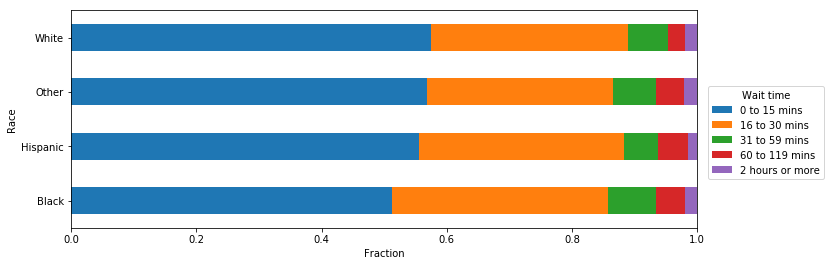

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

wait_df.plot(kind='barh', stacked=True, legend=False, ax=ax)
ax.set_xlabel('Fraction')
ax.set_xlim(0, 1)
ax.set_ylabel('Race')

fig.subplots_adjust(right=0.85)

legend = fig.legend(*ax.get_legend_handles_labels(), loc='center right')
legend.set_title('Wait time')
legend.set_alpha(1.0)

We can also plot the transpose version of this:

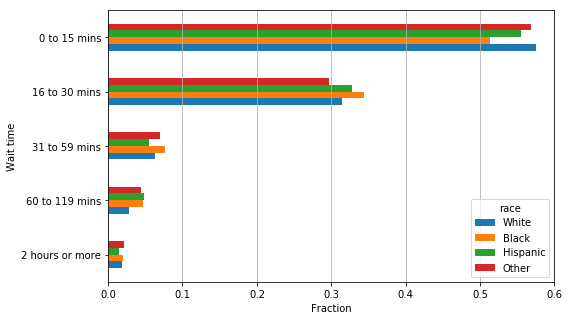

In [8]:
wait_df = pd.DataFrame({'race': race, 'wait_time': wait})
wait_df = wait_df[(df.IV_RACE is not 4) & (df.ACC_D_GETUS > 0)]

# now bin the values
wait_df = wait_df.groupby('wait_time').apply(lambda x: (x.race.value_counts()))

# and convert to percentages
wait_df = wait_df.apply(lambda x: x / x.sum(), axis=0).sort_values(by='White')

# and plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
wait_df.plot(kind='barh', ax=ax, )

ax.grid('on', axis='x')
ax.set_xlim(0, 0.6)
ax.set_xlabel('Fraction')
ax.set_ylabel('Wait time')

I recall that the student used three bins: `< 1 hr`, `1 - 2 hrs`, and `> 2 hrs`. Let's try this too:

wait_time,< 1 hr,1 - 2 hrs,> 2 hrs
race,,,
Black,0.933190,0.046695,0.020115
Hispanic,0.937607,0.047863,0.014530
Other,0.934667,0.044000,0.021333
White,0.952396,0.028460,0.019144


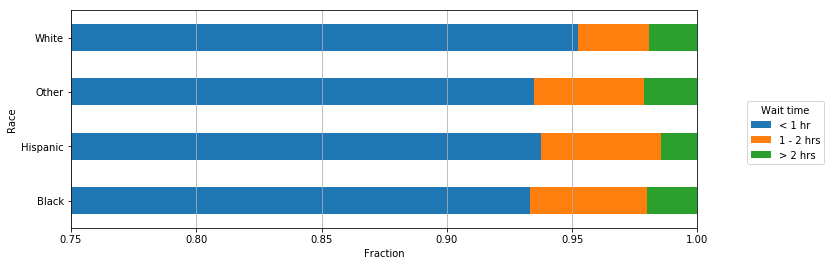

In [9]:
wait_df = pd.DataFrame({'race': race, 'wait_time': wait})
wait_df = wait_df[(df.IV_RACE is not 4) & (df.ACC_D_GETUS > 0)]

# bin the values
wait_df = wait_df.groupby('race').apply(lambda x: (x.wait_time.value_counts()))

# change the binning
wait_df['< 1 hr'] = wait_df[['0 to 15 mins', '16 to 30 mins', '31 to 59 mins']].sum(axis=1)
wait_df['1 - 2 hrs'] = wait_df['60 to 119 mins']
wait_df['> 2 hrs'] = wait_df['2 hours or more']

wait_df.drop(['0 to 15 mins', '16 to 30 mins', '31 to 59 mins', '60 to 119 mins', '2 hours or more'], axis=1, inplace=True)

# and convert to percentages
wait_df = wait_df.apply(lambda x: x / x.sum(), axis=1)


# plot as above
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

wait_df.plot(kind='barh', stacked=True, legend=False, ax=ax)
ax.set_xlabel('Fraction')
ax.set_xlim(0.75, 1)
ax.set_ylabel('Race')
ax.grid('on', axis='x')

fig.subplots_adjust(right=0.85)

legend = fig.legend(*ax.get_legend_handles_labels(), loc='center right')
legend.set_title('Wait time')
legend.set_alpha(1.0)

# show table
wait_df

To me, it looks like there exists some disparity in wait times. A larger fraction of White patients wait for under an hour compared to Black, Hispanic, and Other populations. Fewer people in the White category also wait 1-2 hours. However, for over two hour waits, they do not seem to have the "advantage" anymore.